In [37]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg'

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram

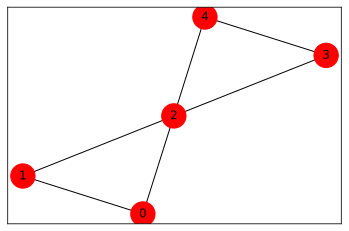

In [3]:
n = 5
V = np.arange(0, n, 1)
E = [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (3, 2, 1.0), (3, 4, 1.0), (4, 2, 1.0)]

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

## Optimal Trial State Parameters

In [5]:
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
a_beta = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma, a_beta)

a_gamma, a_beta

(array([[0. , 0.1, 0.2, ..., 2.9, 3. , 3.1],
        [0. , 0.1, 0.2, ..., 2.9, 3. , 3.1],
        [0. , 0.1, 0.2, ..., 2.9, 3. , 3.1],
        ...,
        [0. , 0.1, 0.2, ..., 2.9, 3. , 3.1],
        [0. , 0.1, 0.2, ..., 2.9, 3. , 3.1],
        [0. , 0.1, 0.2, ..., 2.9, 3. , 3.1]]),
 array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        ...,
        [2.9, 2.9, 2.9, ..., 2.9, 2.9, 2.9],
        [3. , 3. , 3. , ..., 3. , 3. , 3. ],
        [3.1, 3.1, 3.1, ..., 3.1, 3.1, 3.1]]))

In [6]:
F1 = 3 - (np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma)*(1 +np.cos(4*a_gamma)**2))

In [8]:
result = np.where(F1 == np.amax(F1))

In [9]:
result

(array([19]), array([2]))

In [18]:
a = list(zip(result[0], result[1]))[0]

In [19]:
a

(19, 2)

In [20]:
gamma = a[0] * step_size
beta = a[1] * step_size

In [21]:
gamma, beta

(1.9000000000000001, 0.2)

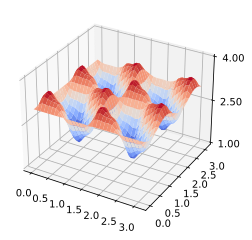


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.459
This is attained for gamma = 1.900 and beta = 0.200


In [25]:
"""
Plot the expectation value of F1
"""
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_zlim(1, 4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.show()

print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

## Quantum Circuit

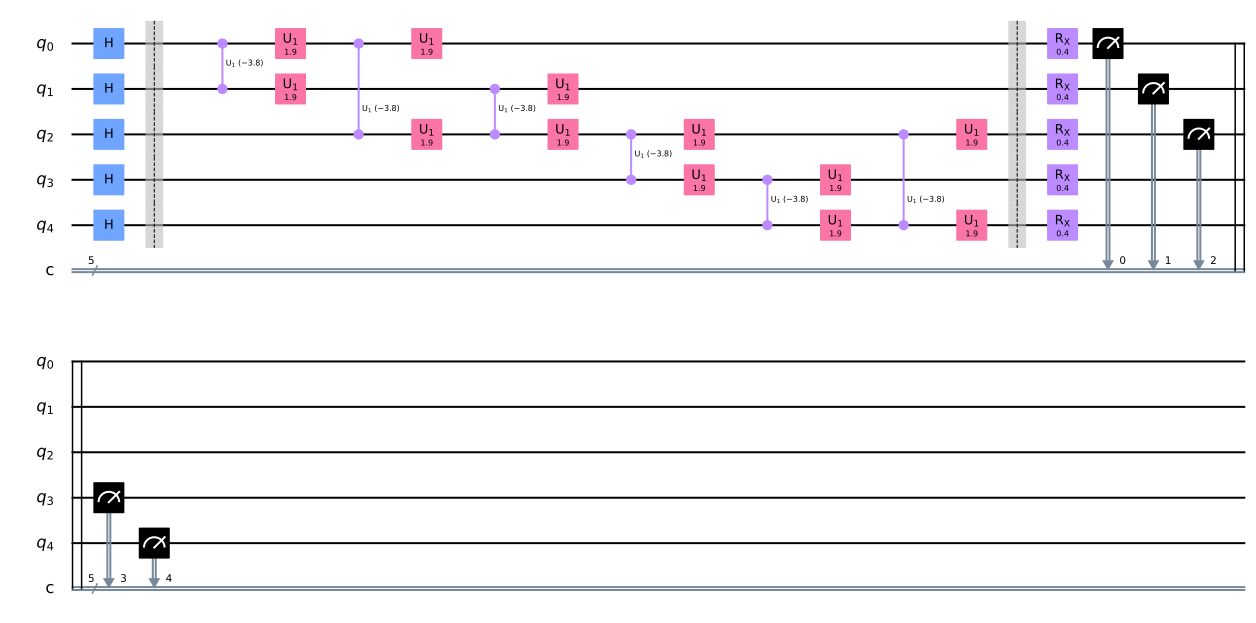

In [34]:
# Prepare quantum and classical registers
qaoa = QuantumCircuit(len(V), len(V))

# Prepare initial state in superposition of all possible states via Hadamard gates
qaoa.h(range(len(V)))
qaoa.barrier()

# Appply Ising type gates with angle gamma aldon the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    qaoa.cu1(-2*gamma, k, l)
    qaoa.u1(gamma, k)
    qaoa.u1(gamma, l)
qaoa.barrier()

# Apply the single qubit X rotation with angle beta to all the qubits
qaoa.rx(2*beta, range(len(V)))

# Measure the result in the computational basis
qaoa.measure(range(len(V)), range(len(V)))
qaoa.draw(output='mpl')

## Cost Function Evaluation

In [40]:
def cost_function_C(x, G):
    E = G.edges()
    if (len(x) != len(G.nodes())):
        return np.nan
    C = 0
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w = G[e1][e2]['weight']
        C += w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
    return C

## Qaoa On The Simulator

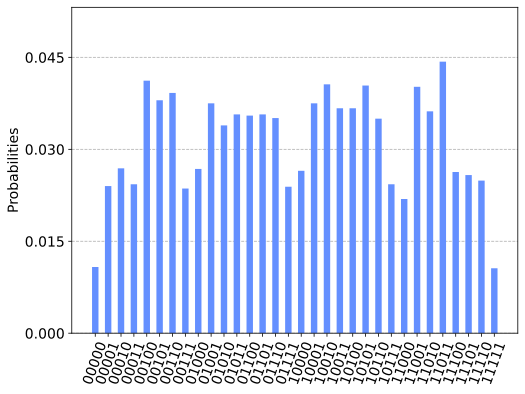

In [38]:
backend = Aer.get_backend("qasm_simulator")
shots = 10000

simulate = execute(qaoa, backend=backend, shots=shots)
qaoa_results = simulate.result()

plot_histogram(qaoa_results.get_counts(), figsize=(8, 6), bar_labels=False)

## Evaluate Experiment Data


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.32 while the true value is M1 = 3.46 

The approximate solution is x* = 10001 with C(x*) = 4 

The cost function is distributed as: 



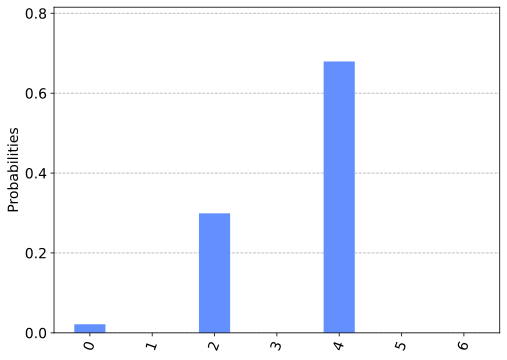

In [42]:
counts = qaoa_results.get_counts()

avr_C = 0
max_C = [0, 0]
hist = {}

for k in range(len(G.edges()) + 1):
    hist[str(k)] = hist.get(str(k), 0)
    
for sample in list(counts.keys()):
    
    # Use sampled bit string x to compute C(x)
    x = [int(num) for num in list(sample)]
    tmp_eng = cost_function_C(x, G)
    
    avr_C += counts[sample] * tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)), 0) + counts[sample]
    
    # Save best bit string
    if max_C[1] < tmp_eng:
        max_C[0] = sample
        max_C[1] = tmp_eng
        
M1_sampled = avr_C/shots
    
print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)